In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import src.common as common
import src.ranking as ranking
import src.data_loading as data_loading
import src.data_transformation as data_transformation
import src.user_profile as user_profile
import src.test as test
import src.visualization as visualization
import traceback

ModuleNotFoundError: No module named 'src'

In [2]:
data_loader = data_loading.DataLoader('../data')
movies_df = data_loader.load_movies()
ratings_df = data_loader.load_ratings()

NameError: name 'data_loading' is not defined

In [3]:
# split the data into train and test sets
train_set, test_set = test.RankingTest.split_ratings_into_train_test(ratings_df.copy(), seed=42, k=10)
movie_rec_df = data_transformation.DataTransformer.transform_data(movies_df, train_set)
results = []

In [4]:
from src.models import AprioriKmeansRecommender, AprioriSimplestRecommender, SimpleRegressionRecommender, SVDRecommender, RidgeKmeansRecommender, KMeansRecommender

model = AprioriKmeansRecommender(movie_rec_df, min_support=0.05, k=31, min_confidence=0.6)
model.fit(train_set)
simple_recommender = AprioriSimplestRecommender(movie_rec_df, min_support=0.1, min_confidence=0.5)
simple_regression_recommender = SimpleRegressionRecommender(movie_rec_df)
svd_recommender = SVDRecommender(movie_rec_df, n_epochs=25, n_factors=200)
svd_recommender.fit(train_set)
gb_recommender = RidgeKmeansRecommender(movie_rec_df)
gb_recommender.fit(train_set)
kmeans_recommender = KMeansRecommender(movie_rec_df, k=15)
kmeans_recommender.fit(train_set)

In [19]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
res = []
res_penalize = []
res_simple = []
res_simple_reg = []
res_svd_recommender = []
res_gb_recommender = []
res_kmeans_recommender = []
i = 0
for test_user in test_set['userId'].unique().tolist():
    test_user_ratings = train_set[train_set['userId'] == test_user]
    evaluation_ratings = test_set[test_set['userId'] == test_user]
    recommendations = model.recommend_for_user(test_user_ratings, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res.append(corr)
    recommendations = model.recommend_for_user(test_user_ratings,  evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings), penalize_genres=True)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_penalize.append(corr)
    recommendations = simple_recommender.recommend_for_user(test_user_ratings,  evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings), penalize_genres=False)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_simple.append(corr)
    recommendations = simple_regression_recommender.recommend_for_user(test_user_ratings, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_simple_reg.append(corr)
    recommendations = svd_recommender.recommend_for_user(test_user_ratings, test_user, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_svd_recommender.append(corr)
    recommendations = gb_recommender.recommend_for_user(test_user_ratings, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_gb_recommender.append(corr)
    recommendations = kmeans_recommender.recommend_for_user(test_user_ratings, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_kmeans_recommender.append(corr)
    i += 1
    if i > 1000:
        break


KeyboardInterrupt: 

In [8]:
res = [r for r in res if r is not np.nan]
res_penalize = [r for r in res_penalize if r is not np.nan]
res_simple = [r for r in res_simple if r is not np.nan]
res_simple_reg = [r for r in res_simple_reg if r is not np.nan]
res_svd_recommender = [r for r in res_svd_recommender if r is not np.nan]
res_gb_recommender = [r for r in res_gb_recommender if r is not np.nan]
res_kmeans_recommender = [r for r in res_kmeans_recommender if r is not np.nan]

In [9]:
res_map = [
    (res, "Main recommender"),
    (res_penalize, "Main recommender penalize"),
    (res_simple, "Simple apriori recommender"),
    (res_simple_reg, "Simple regression recommender"),
    (res_svd_recommender, "SVD recommender"),
    (res_gb_recommender, "GB recommender"),
    (res_kmeans_recommender, "KMeans recommender")
                                                
]

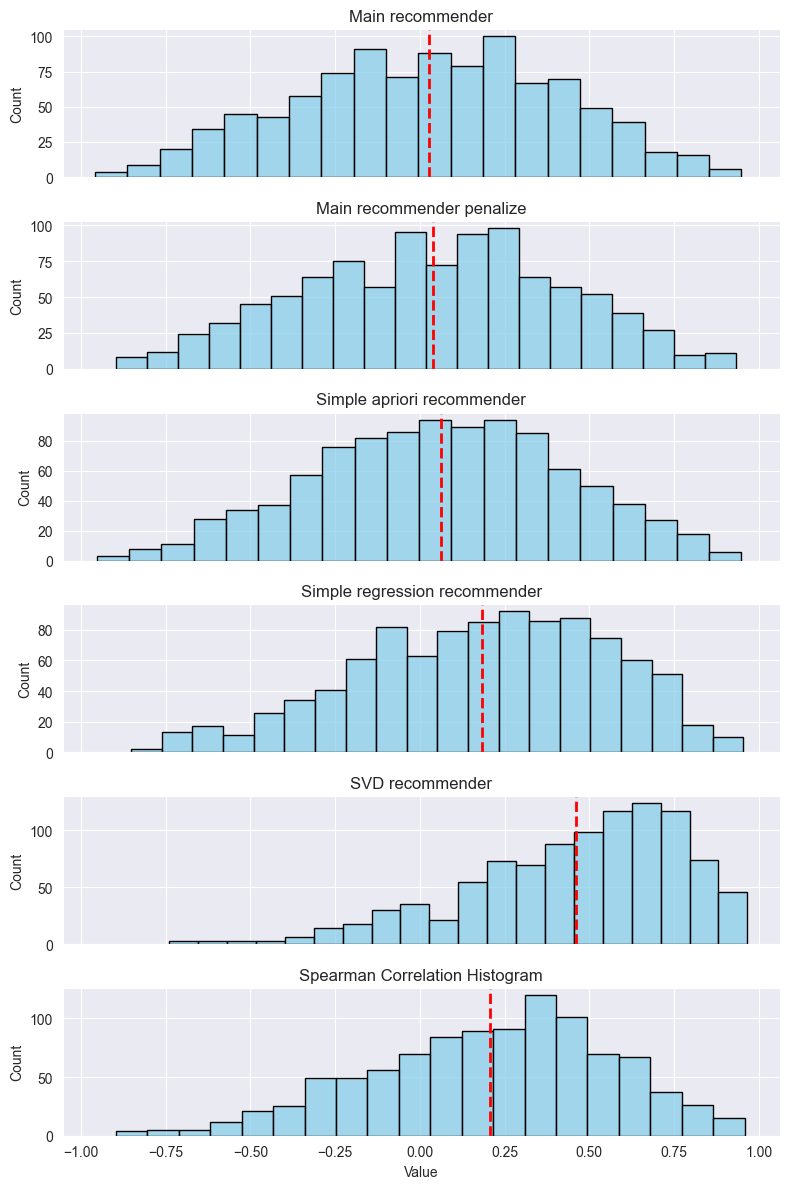

In [10]:
visualization.visualize_multiple_hist(res_map, "Spearman Correlation Histogram")

In [12]:
print('Apriori Kmeans', np.mean(res))
print('Apriori Kmeans Pen', np.mean(res_penalize))
print('Apriori Simple', np.mean(res_simple))
print('Simple Reg', np.mean(res_simple_reg))
print('SVD', np.mean(res_svd_recommender))
print('Ridge', np.mean(res_gb_recommender))
print('KMeans', np.mean(res_kmeans_recommender))

Apriori Kmeans 0.02788665721367276
Apriori Kmeans Pen 0.037544343929888445
Apriori Simple 0.0610062852497219
Simple Reg 0.18454375898416345
SVD 0.46129100825328884
GB 0.2072648199537498


In [17]:
from src.common import save_model

save_model(svd_recommender, "../model/svd_rec.pkl")